In [1]:
import os
from collections import defaultdict
from glob import glob

import gdown
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from Levenshtein import distance as levenshtein_distance

from IPython.display import Video
from constants import ENCODER, N_EPOCHS, NUM_WORKERS
from utils import load_data, get_largest_epoch, gif_to_mp4
from lip_net import LipNN, load_checkpoint, save_checkpoint
from decoders import get_beam_decoder, decode_tokens

In [2]:
if torch.backends.mps.is_available():
    # 3D convolutions are not yet supported on Apple Silicon ships
    # edit `cpu` to `mps` once the pull request has been merged
    device = torch.device("cpu")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
if not os.path.exists("./data"):
    url = "https://drive.google.com/uc?export=download&id=13ow44Nh_ipD-ckpjHVNLuZ6AH51YFct8"
    output = "data.zip"
    gdown.download(url, output, quiet=False)
    gdown.extractall(output)
    os.remove("./data.zip")

In [4]:
ENCODER.batch_encode(['f','u','n'])

tensor([ 7, 22, 15])

In [5]:
ENCODER.batch_decode(torch.tensor([7, 22, 15]))

['f', 'u', 'n']

In [6]:
frames_test, alignments_test = load_data(path="./data/s1/bras9a.mpg")

In [7]:
frames_test.shape

torch.Size([1, 75, 46, 140])

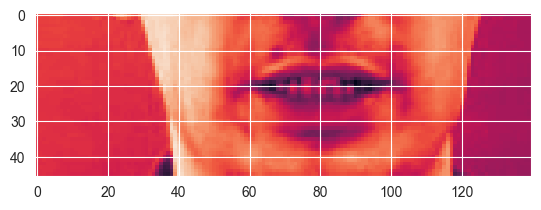

In [8]:
plt.imshow(frames_test.squeeze()[35])

In [9]:
alignments_test

tensor([ 3, 10, 15,  1, 19,  6,  5,  1,  2, 21,  1, 20,  1, 15, 10, 15,  6,  1,
         2,  8,  2, 10, 15])

In [10]:
class VideoDataset(Dataset):
    def __init__(self, file_pattern):
        self.file_paths = glob(file_pattern)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        video_path = self.file_paths[idx]
        return load_data(video_path)

In [11]:
def custom_collate_fn(batch):
    frames, alignments = zip(*batch)
    # define target sizes
    target_frame_size = (1, 75, 46, 140)
    target_alignment_size = 35

    # pad frames
    frames_padded = [
        F.pad(
            frame, 
            pad=(
                0, max(0, target_frame_size[3] - frame.shape[3]),
                0, max(0, target_frame_size[2] - frame.shape[2]), 
                0, max(0, target_frame_size[1] - frame.shape[1]), 
                0, max(0, target_frame_size[0] - frame.shape[0])
            ), 
            value=0
        ) for frame in frames
    ]

    # pad alignments
    alignments_padded = [
        F.pad(align, pad=(0, max(0, target_alignment_size - align.shape[0])), value=0) for align in alignments
    ]
    return torch.stack(frames_padded, dim=0), torch.stack(alignments_padded, dim=0)

In [12]:
dataset = VideoDataset("./data/s1/*.mpg")
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_dataset, 
    batch_size=2, 
    shuffle=True, 
    collate_fn=custom_collate_fn, 
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == "cuda" else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=2, 
    shuffle=False, 
    collate_fn=custom_collate_fn, 
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == "cuda" else False
)

In [13]:
sample_iterator = iter(train_loader)
frames_test, alignments_test = next(sample_iterator)

In [14]:
frames_test.shape

torch.Size([2, 1, 75, 46, 140])

In [15]:
alignments_test.shape

torch.Size([2, 35])

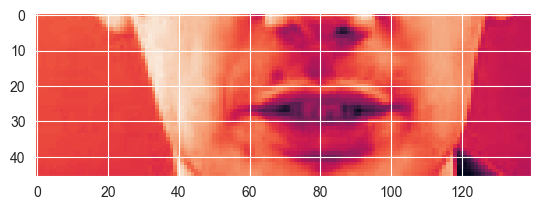

In [16]:
plt.imshow(frames_test[0].squeeze()[35])

In [17]:
imageio.mimsave("./animation.gif", (frames_test[0].squeeze().numpy() * 255), fps=25)
# comment if a ffmpeg executable is not accessible on $PATH
gif_to_mp4()
os.remove("./animation.gif")
Video("./animation.mp4", width=750, html_attributes="loop autoplay", embed=True)

In [18]:
model = LipNN(vocabulary_size=len(ENCODER.index_to_token))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: 1 if x < int(N_EPOCHS * 0.3) else torch.exp(torch.tensor(-0.1)))
ctc_loss = nn.CTCLoss(reduction="mean")
model.to(device)
model.train()
summary(model,(1, 1, 75, 46, 140))

Layer (type:depth-idx)                   Output Shape              Param #
LipNN                                    [1, 75, 28]               --
├─Conv3d: 1-1                            [1, 128, 75, 46, 140]     3,584
├─MaxPool3d: 1-2                         [1, 128, 75, 23, 70]      --
├─Conv3d: 1-3                            [1, 256, 75, 23, 70]      884,992
├─MaxPool3d: 1-4                         [1, 256, 75, 11, 35]      --
├─Conv3d: 1-5                            [1, 75, 75, 11, 35]       518,475
├─MaxPool3d: 1-6                         [1, 75, 75, 5, 17]        --
├─LSTM: 1-7                              [1, 75, 256]              6,661,120
├─Dropout: 1-8                           [1, 75, 256]              --
├─Linear: 1-9                            [1, 75, 28]               7,196
Total params: 8,075,367
Trainable params: 8,075,367
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 124.06
Input size (MB): 1.93
Forward/backward pass size (MB): 759.38
Params size (MB): 32.3

In [19]:
beam_search_decoder = get_beam_decoder(device.type)

In [20]:
def test_example(x, y):
    model.eval()
    with torch.no_grad():
        logits = model(x.to(device)).log_softmax(dim=2)
        decoded = beam_search_decoder(logits, torch.full(size=(x.shape[0],), fill_value=x.shape[2], dtype=torch.int32).to(device))
        predictions = decode_tokens(decoded, device.type)
        targets = [''.join(ENCODER.index_to_token[z] for z in sentence) for sentence in y]
        for target, prediction in zip(targets, predictions):
            print(f"target: {target}\n"
                  f"prediction: {prediction}" + '\n' + '-' * 65)

In [21]:
test_example(frames_test, alignments_test)

target: lay white at z zero now
prediction: dcdcdcdcdcdcdcrdrcdvdwdrdrcdcdrdrcdcd
-----------------------------------------------------------------
target: place white at d two now
prediction: dbrcdcdrcdrdvdcvcrdrbdcrcdrcdubrcdbcrdrcdcrdd
-----------------------------------------------------------------


In [22]:
# resume training
epoch_q0 = get_largest_epoch()
if epoch_q0 != -1:
    load_checkpoint(model, epoch_q0, device, optimizer)
else:
    epoch_q0 = 0

In [23]:
def train():
    for epoch in range(epoch_q0, N_EPOCHS):
        print(f"Epoch {epoch + 1}/{N_EPOCHS} started.")
        model.train()
        for data in train_loader:
            inputs, targets = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(inputs)
    
            # Calculate loss
            outputs = torch.permute(outputs.log_softmax(dim=2), (1, 0, 2))
            T, N, C = outputs.shape
            S = targets.shape[1]
            input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long).to(device)
            target_lengths = torch.full(fill_value=S, size=(N,), dtype=torch.long).to(device)
            loss = ctc_loss(outputs, targets, input_lengths, target_lengths)
    
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        save_checkpoint(epoch + 1, model, optimizer)
        test_example(frames_test, alignments_test)

In [24]:
# train()

In [25]:
# n = 2k since N = 2
def test_examples(n=3):
    for i, data in enumerate(test_loader):
        if i == n:
            break
        test_example(*data)

def test_models():
    for i in [50, 100, 150, 200]:
        load_checkpoint(model, i)
        print('-' * 65 + '\n' + f"Testing the model with the weights at the {i}th epoch." + '\n' + '-' * 65)
        test_examples()
        
test_models()

-----------------------------------------------------------------
Testing the model with the weights at the 50th epoch.
-----------------------------------------------------------------
target: place red in c two now
prediction: plac red it y two now
-----------------------------------------------------------------
target: bin white by n five again
prediction: plac white by t ewo again
-----------------------------------------------------------------
target: lay white sp by f three soon
prediction: lay white it three soon
-----------------------------------------------------------------
target: set red in a nine again
prediction: siy red it a five again
-----------------------------------------------------------------
target: lay white in k eight now
prediction: lay white it t sigh now
-----------------------------------------------------------------
target: lay blue in x five soon
prediction: lay blue it d five soon
-----------------------------------------------------------------
---

In [26]:
def calculate_cer(reference, hypothesis):
    return levenshtein_distance(reference, hypothesis) / len(reference)

def calculate_wer(reference, hypothesis):
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()
    return levenshtein_distance(reference_words, hypothesis_words) / len(reference_words)

def calculate_bleu(reference, hypothesis):
    reference = reference.split()
    hypothesis = hypothesis.split()
    return sentence_bleu([reference], hypothesis, smoothing_function=SmoothingFunction().method1)

In [27]:
def evaluate_model():
    metrics = defaultdict(list)
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            x, y = data[0].to(device), data[1].to(device)
            logits = model(x).log_softmax(dim=2)
            decoded = beam_search_decoder(logits, torch.full(size=(x.shape[0],), fill_value=x.shape[2], dtype=torch.int32).to(device))
            predictions = decode_tokens(decoded, device.type)
            targets = [''.join(ENCODER.index_to_token[z] for z in sentence) for sentence in y]
            for target, prediction in zip(targets, predictions):
                metrics["CER"].append(calculate_cer(target, prediction))
                metrics["WER"].append(calculate_wer(target, prediction))
                metrics["BLEU"].append(calculate_bleu(target, prediction))
    return {k: sum(v) / len(v) for k, v in metrics.items()}

stats = evaluate_model()
stats

{'CER': 0.03878365434887174,
 'WER': 0.07142857142857142,
 'BLEU': 0.887551563503466}

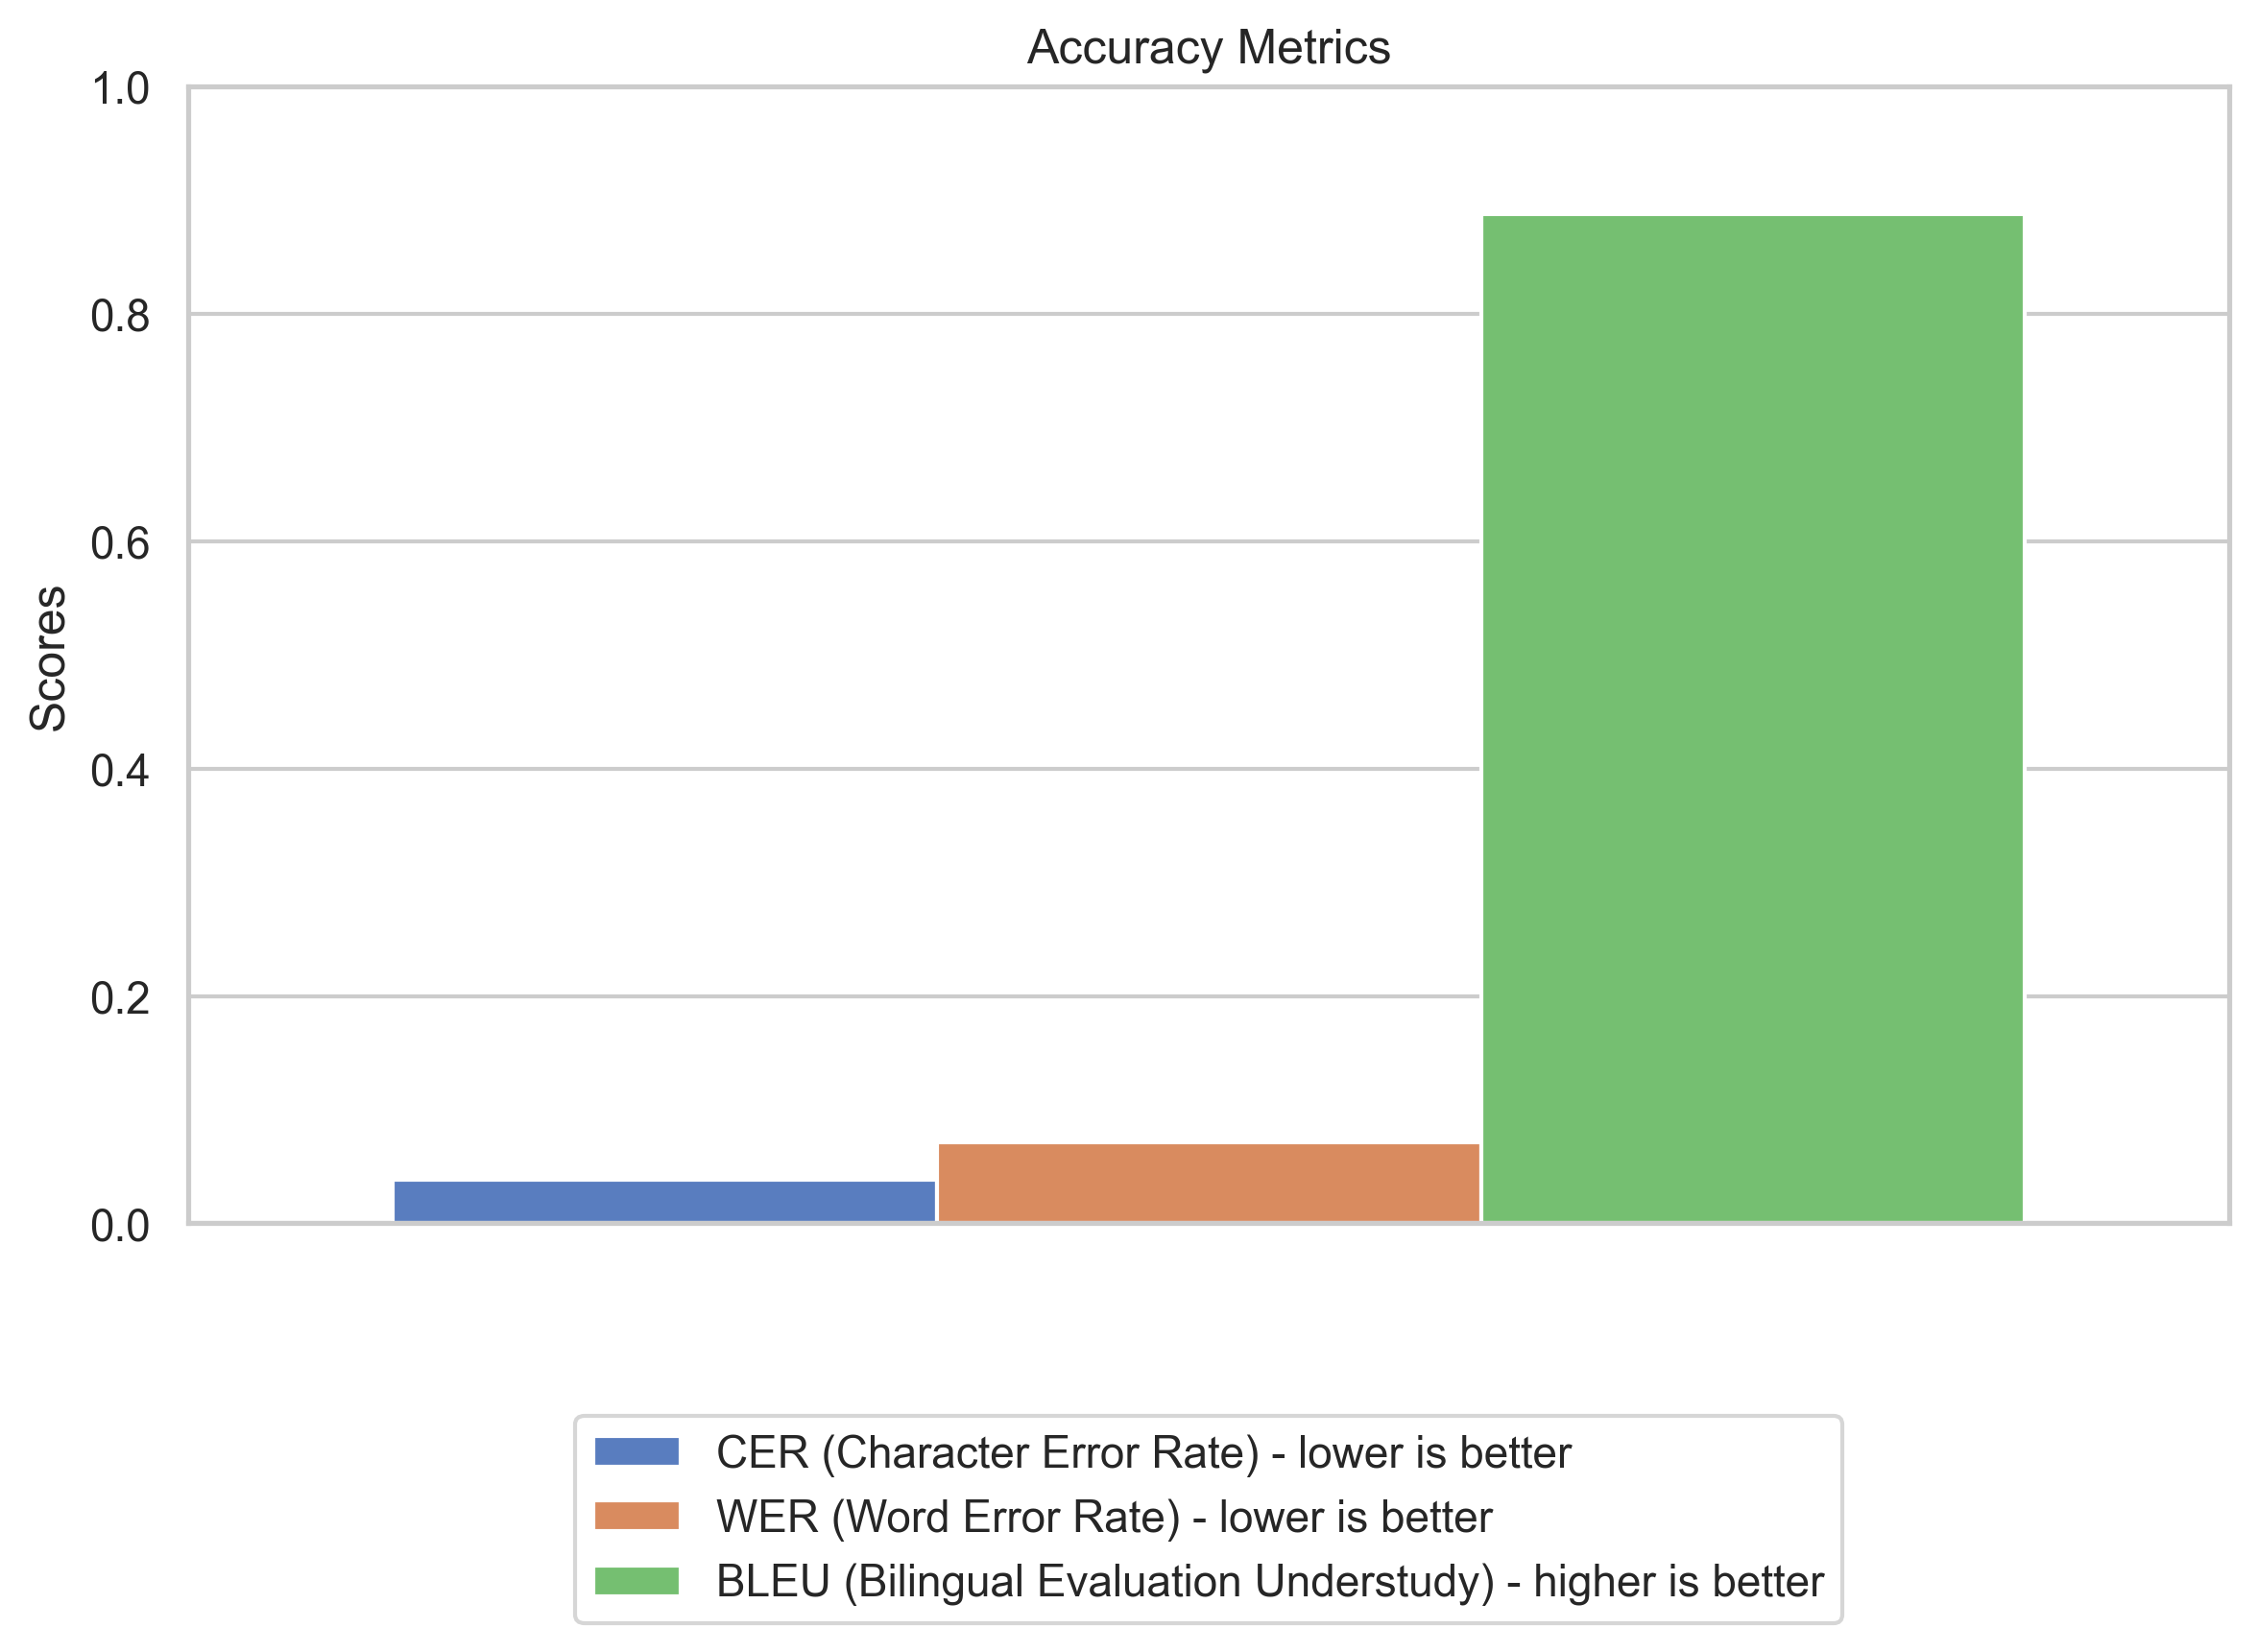

In [28]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
sns.barplot(hue=list(stats.keys()), y=list(stats.values()), ax=ax, palette="muted", legend=False)

ax.set_ylabel("Scores")
ax.set_title("Accuracy Metrics")
ax.set_ylim(0, 1)

legend_labels = ["CER (Character Error Rate) - lower is better",
                 "WER (Word Error Rate) - lower is better",
                 "BLEU (Bilingual Evaluation Understudy) - higher is better"]
ax.legend(ax.patches, legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.show()